In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob 
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [19]:
Grape_Black_rot_images = glob("dataset/Grape/Grape___Black_rot/*.jpg")
Grape_Esca_images = glob("dataset/Grape/Grape___Esca_(Black_Measles)/*.jpg")
Grape_healthy_images = glob("dataset/Grape/Grape___healthy/*.jpg")
Grape_Leaf_blight_images = glob("dataset/Grape/Grape___Leaf_blight/*.jpg")

In [20]:
print(f"Number of Grape_Black_rot_images: {len(Grape_Black_rot_images)}")
print(f"Number of Grape_Esca_images: {len(Grape_Esca_images)}")
print(f"Number of Grape_healthy_images: {len(Grape_healthy_images)}")
print(f"Number of Grape_Leaf_blight_images: {len(Grape_Leaf_blight_images)}")

Number of Grape_Black_rot_images: 1180
Number of Grape_Esca_images: 1383
Number of Grape_healthy_images: 423
Number of Grape_Leaf_blight_images: 1076


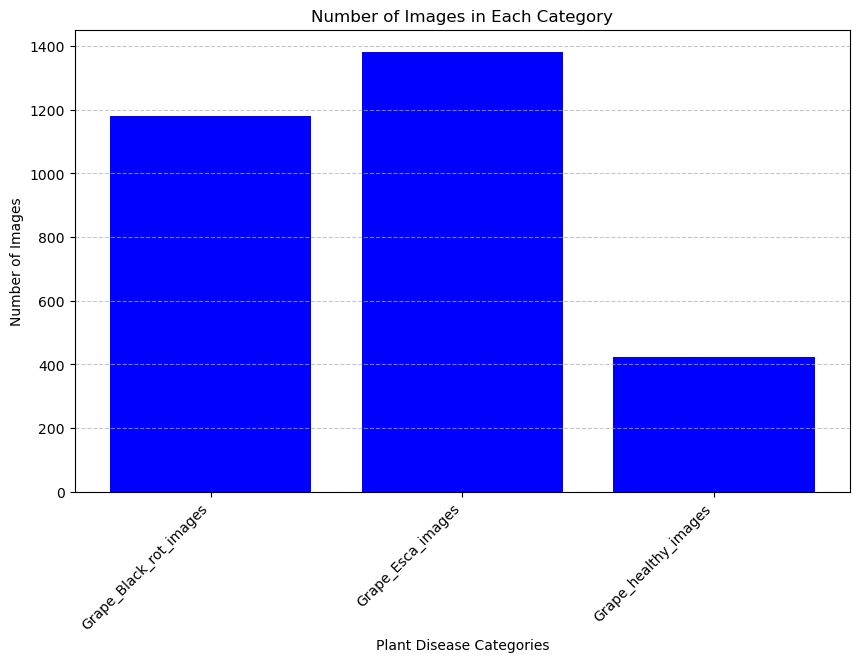

In [21]:
labels = ["Grape_Black_rot_images","Grape_Esca_images","Grape_healthy_images"]
counts = [len(Grape_Black_rot_images),len(Grape_Esca_images),len(Grape_healthy_images),len(Grape_Leaf_blight_images)]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

# Add labels and title
plt.xlabel("Plant Disease Categories")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Category")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [22]:


IMG_SIZE = (128, 128)

def load_images(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sorted for consistency
    label_map = {name: idx for idx, name in enumerate(class_names)}  # Label encoding

    for label in class_names:
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for file in glob(os.path.join(class_folder, "*.jpg")):  # Load only images
                img = cv2.imread(file)
                if img is None:
                    continue  # Skip unreadable images

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, IMG_SIZE)  # Resize image
                img = img / 255.0  # Normalize pixels (0-1)
                
                images.append(img)
                labels.append(label_map[label])  # Store numerical label
    
    return np.array(images), np.array(labels), label_map  # Return label map for decoding



In [23]:
X, y, z = load_images('dataset/Grape')
print(f"Loaded {len(X)} images with {len(set(y))} classes.")

Loaded 4062 images with 4 classes.


In [24]:
print(z)

{'Grape___Black_rot': 0, 'Grape___Esca_(Black_Measles)': 1, 'Grape___Leaf_blight': 2, 'Grape___healthy': 3}


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2 , random_state = 42)

In [26]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [27]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(4, activation='softmax')  # 3 Output Neurons
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize & split

train_generator = datagen.flow_from_directory(
    'dataset/Grape',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'dataset/Grape',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# **Compute class weights from the directory**
class_counts = train_generator.class_indices  # Get class labels
class_samples = train_generator.samples  # Total training images

# Get label distribution
labels = list(class_counts.values())  # Numeric labels
class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=np.array(labels),
    y=np.repeat(labels, [class_samples])  # Fake labels for weight calculation
)

class_weights = {i: weight for i, weight in zip(labels, class_weight_values)}
print("Computed Class Weights:", class_weights)

# Train model using generator
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping],
     class_weight=class_weights
)


Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Computed Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
Epoch 1/10
  1/102 [..............................] - ETA: 8:35 - loss: 1.3526 - accuracy: 0.4062

In [ ]:
train_generator.num_classes

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
model.save("Grapes_Disease.h5")
